In [4]:
%load_ext autoreload
%autoreload 2
import torch

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache_bert')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> current directory : c:\Users\loicf\Documents\IRISA\AttentionGeometry
>> cache path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert
>> model path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\models
>> dataset path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\dataset
>> logs path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_bert\logs


In [5]:
DEVICE

device(type='cuda')

In [6]:
from datasets import load_dataset
dataset = load_dataset("yelp_polarity", split='test')

Reusing dataset yelp_polarity (C:\Users\loicf\.cache\huggingface\datasets\yelp_polarity\plain_text\1.0.0\14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61)


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\loicf\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [8]:
def tokenize_function(data):
  return tokenizer(data["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/38 [00:00<?, ?ba/s]

In [9]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(log_path, "yelp", "yelp-ft-3"),
    num_labels=2,
    output_hidden_states=True
)
model = model.eval()

In [10]:
# get the r_i
import numpy as np
class_1 = 0
r_0 = None
for i in range(len(tokenized_datasets)):
    ex = tokenized_datasets[i]
    label = tokenized_datasets[i]["label"]
    ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
    att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
    output_model = model(
        input_ids = ids, 
        attention_mask = att_mask
    )
    pred = output_model.logits
    if label == class_1 and np.argmax(pred.detach().cpu().numpy()) == label:
        print( np.argmax(pred.detach().cpu().numpy()))
        print(label)
        r_0 = output_model.hidden_states[-1][0, 0, :]
        print("pred found")
        break

0
0
pred found


In [12]:
r_0.shape

torch.Size([768])

In [15]:
cos_res = []
legend = []
ds = tokenized_datasets
from tqdm.notebook import tqdm
model = model.to(DEVICE)
model = model.eval()
r_0 = r_0.to(DEVICE)
with torch.no_grad():
    for i in tqdm(range(len(tokenized_datasets))):
        ex = ds[i]
        label = ex["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE),
        )

        temp = output_model.hidden_states[-1][0, 0, :]
        scalar = torch.dot(r_0, temp)
        cos_res.append((scalar / (torch.norm(temp) * torch.norm(r_0))).item())
        legend.append(label)
        if i > 5000:
            break

  0%|          | 0/38000 [00:00<?, ?it/s]

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


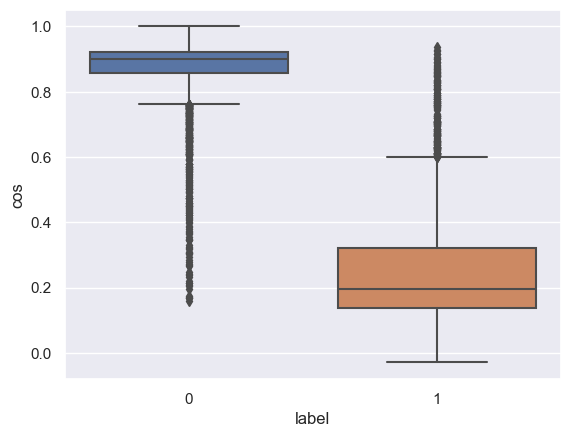

In [18]:
df = pd.DataFrame({
    "cos": cos_res,
    "label":legend
})

sns.boxplot(data=df, x = "label", y="cos")
plt.savefig(".cache_bert/plots/paper/yelp_cos_class.png")